In [1]:
import OffsetArrays
using Plots
using Revise
using StatsBase
using ProgressMeter
using SparseArrays, LinearAlgebra, IndexedGraphs, Graphs
using Distributions
srcpath = "../src"
include("$srcpath/bp.jl")
include("$srcpath/post_infer.jl")
include("$srcpath/observables.jl")

avg_ninf (generic function with 1 method)

In [2]:
function δλ(infer_lam)
    if infer_lam
        return 0.001im
    else
        return 0.0
    end
end
function δsympt(infer_sympt)
    if infer_sympt
        return 0.001im
    else
        return 0.0
    end
end

δsympt (generic function with 1 method)

In [3]:
# S=0   I=1
# The times go from ti = 0 to ti=T+1
# when ti=0 it means that i is the zero patient
# when ti=T+1 it means that i is never infected

λp = 0.25 # planted infection rate
λi = 0.25 #inferred infection rate

infer_lam = false #set it true if you want to infere the prior parameter λ
infer_gam = false #set it true if you want to infere the prior parameter γ


T = 8 # discrete time

γp = 0.03 # planted autoinfection probability
γi = 0.03 # inferred autoinfection probability

N = 3000; #population size; paer results obtained for N=3*10^5
dilution = 0.0
fr = 0.0;


# Comparison trigger VS random

In [4]:
#right trigger
degree_dist = Poisson(3)
M = ParametricModel(N = N, T = T, γp = γp, λp = λp, γi=γi, λi=λi + δλ(infer_lam), fr=fr, distribution=degree_dist, field=0.0, p_test_pla=0.04,p_sympt_pla=0.5,p_sympt_inf=0.5 ) ;
pop_dynamics(M, tot_iterations = 80, eta = 0.1, infer_lam=infer_lam, infer_gam=infer_gam)
marg = M.belief |> real;
marg2Dt = reshape(sum(marg,dims=3) ./ N, T+2,T+2)
ensAUC = avgAUC(marg,M.obs_list,count_obs=true); #set false to see the AUC only on NON observed indiv.

In [5]:
#random assumption
M = ParametricModel(N = N, T = T, γp = γp, λp = λp, γi=γi, λi=λi + δλ(infer_lam), fr=fr, distribution=degree_dist, field=0.0, p_test_pla=0.04,p_sympt_pla=0.5,p_sympt_inf=0.0 ) ;
pop_dynamics(M, tot_iterations = 80, eta = 0.1, infer_lam=infer_lam, infer_gam=infer_gam)
marg1 = M.belief |> real;
marg2D = reshape(sum(marg1,dims=3) ./ N, T+2,T+2)
ensAUC1 = avgAUC(marg1,M.obs_list,count_obs=true); #set false to see the AUC only on NON observed indiv.

In [6]:
#inferring trigger
infer_sympt = true
degree_dist = Poisson(3)
M = ParametricModel(N = N, T = T, γp = γp, λp = λp, γi=γi, λi=λi + δλ(infer_lam), fr=fr, distribution=degree_dist, field=0.0, p_test_pla=0.04,p_sympt_pla=0.5,p_sympt_inf=0.1 + δsympt(infer_sympt) ) ;
F,tot_it = pop_dynamics(M, tot_iterations = 150, eta = 0.03, infer_lam=infer_lam, infer_gam=infer_gam, infer_sympt=infer_sympt,nonlearn_iters=10)
marginf = M.belief |> real;
marg2Dinf = reshape(sum(marginf,dims=3) ./ N, T+2,T+2)
ensAUCinf = avgAUC(marginf,M.obs_list,count_obs=true); #set false to see the AUC only on NON observed indiv.

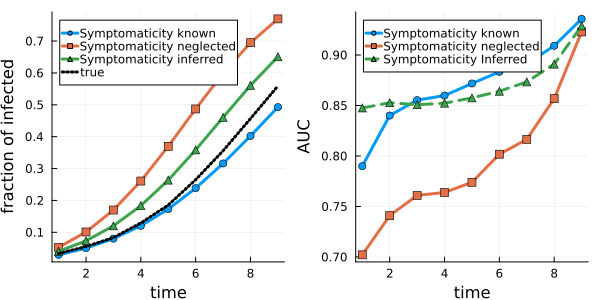

In [7]:

p1 = plot(ensAUC,label="Symptomaticity known",marker=:c)
p1 = plot!(ensAUC1,label="Symptomaticity neglected",marker=:square,ylabel="AUC",linewidth=3)
p1 = plot!(ensAUCinf,label="Symptomaticity Inferred",linestyle=:dash,marker=:utriangle)

p0 = plot(cumsum(sum(marg2Dt,dims=2)[1:end-1],dims=1),marker=:circle,legend=:topleft,label="Symptomaticity known",ylabel="fraction of infected")
p0 = plot!(cumsum(sum(marg2D,dims=2)[1:end-1],dims=1),marker=:square,label="Symptomaticity neglected")
p0 = plot!(cumsum(sum(marg2Dinf,dims=2)[1:end-1],dims=1),marker=:utriangle,label="Symptomaticity inferred")
p0 = plot!(cumsum(sum(marg2D,dims=1)'[1:end-1],dims=1),c=:black,linestyle=:dot,label="true")

plot(p0,p1,size=(600,300),linewidth=3,xlabel="time")
#savefig("./obs_trig.pdf")